In [1]:
%matplotlib inline

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.decomposition import PCA

from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix

from sklearn.ensemble import RandomForestClassifier

# from yellowbrick.classifier import ROCAUC, ConfusionMatrix
# from yellowbrick.model_selection import LearningCurve, learning_curve


import os, shutil, joblib

import upsilon

list_cephs = pd.DataFrame(os.listdir('../csv_data/SMC/cep/I/'))
list_bin = pd.DataFrame(os.listdir('../csv_data/SMC/bin/I/'))

list_cephs = os.listdir('../csv_data/SMC/cep/I/')
list_bin = os.listdir('../csv_data/SMC/bin/I/')[:len(list_cephs)]

plt.style.use('fast')


-------------------------------
* WARNING: No pyFFTW detected *
-------------------------------


# Variable Stars Classification. Use case for random forests

### Contents

1. Introduction
2. Data preparation and feature extraction
3. Model training
   - Prerequisets
   - Training
4. Testing and validation
5. Conclusion
6. References

## 1. Introduction

Here I give an overview of my project, mentioning quickly key moments in every main section that is yet to come.

This project aims to classify variable stars from the Small Magellanic Cloud (SMC) using photometric data from the OGLE Collection of Variable Stars. The project focuses on two classes of variable stars: Classical Cepheids (CEPs) and Eclipsing and Binary Stars (ECLs). The data for these classes was extracted from the SMC using the UPSILoN library.

The main objectives of the project are to:

* Extract photometric features from the time series data for CEPs and ECLs.
* Train a machine learning model to classify CEPs and ECLs.
* Evaluate the performance of the model on unseen data.

**Data preparation and feature extraction**

The data for this project was obtained from the [OGLE Collection of Variable Stars](https://ogledb.astrouw.edu.pl/~ogle/OCVS/). The data was downloaded as two archived files, one for CEPs and one for ECLs. Each archive file contains two folders, one for near-infrared (I-band) data and one for visible (V-band) data. The I-band data was used for this project because it has more objects.

The data for each object is stored in a separate `.dat` file. Each `.dat` file contains time series data for the object, including its magnitude and error. The data was extracted from the `.dat` files using the UPSILoN library.

**Feature Extraction**

The UPSILoN library was used to extract the following features from the time series data:

* Kurtosis
* Skewness
* Number of points
* Height-to-length amplitude ratio
* Period signal-to-noise ratio
* Phase eta
* Stetson K
* Weighted mean
* Quartile 31
* Shapiro-Wilk W statistic
* R21 correlation coefficient
* Period
* R31 correlation coefficient
* Slope per 90 points
* Phase cusum
* Amplitude
* Slope per 10 points
* Period uncertainty
* Weighted standard deviation
* Cusum
* Eta
* Period logarithmic false alarm probability
* Phi21 correlation coefficient
* Phi31 correlation coefficient

**Model taining**

A Random Forest classifier was used to classify CEPs and ECLs. This classifier was chosen because it is able to learn to classify complex data and it can classify multiple classes.

The data was split into training and testing sets. The training set was used to train the model, and the testing set was used to evaluate the performance of the model.

**Testing and validation**

The performance of the model was evaluated using the following metrics:

* Accuracy
* Recall
* Precision
* F1-score
* ROC AUC

The model was able to achieve an accuracy of 100% on the training set and an accuracy of 100% on the testing set, leading to the conclusion of model overfitting. The model achieved a recall of 0.7 for CEPs and 0.6 for ECLs on separate unseen datasets from BLG (Galactic bulge) and LMC (Large Magellanic Cloud).

## 2. Data preparation and feature extraction

In this section we will discuss how to the data has been gathered, processed (prepared) and how the light-curve features have been extracted. 

The data pre-process pipeline:
    - Gather data from catalogue
    - Feature extraction using UPSILoN
    - Saving into one large dataset

First we start with data extraction and preparation.

### Data prep:


The topics to be covered in this subsection are:
- From where the data has been gathered
- How and why it has been processed
- How and why were the features extracted

The data has been gathered from the [OGLE Collection of Variable Stars](https://ogledb.astrouw.edu.pl/~ogle/OCVS/) which is a catalogue of light-curve data sampled from observations of the Galactic bulge, Galactic disk and Magellanic Clouds.

In it it has data for:
- Classical Cepheids: LMC SMC BLG GD
- Anomalous Cepheids: LMC SMC GAL
- Type II Cepheids: LMC SMC BLG GD
- RR Lyrae: LMC SMC BLG GD
- Long Period Variables (Miras): BLG GD
- delta Scuti: LMC SMC BLG GD
- Heartbeat Stars: LMC SMC BLG
- Transiting Planets: BLG
- Eclipsing and Binary Stars: LMC SMC BLG

We will extract the data for two of those classes: Classical Cepheids (CEPs) and Eclipsing and Binary Stars (ECLs) from the Small Magellanic Cloud (SMC). The reason for choosing two classes is *time* - the time needed to extract the photometric features for only two classes of the same size (4931 objects) took approximately 2 hours and since time constrains I couldn't gather more data. The choice for using data from SMC is simple, it had enough samples (4000+), where ones from BLG had smaller (usually less than 500).

The downloaded data is an archived file (in our case we have two archives, since we have two classes to download). In it we have two folders in which the data is located. Folder one, labelled `I` stands, for *near-infrared* sprectrum, folder two, labelled `V`, stands for *visible* spectrum. Folder `I` has more objects than `V`, so we will use that. **(MOre info neede)**

Once we have downloaded the two archives the files have been located in `../csv_data/SMC/` in which we have, again, two folders: `bin` and `cep` for the two classes. In every one of these folder we have another two folders with the data from different filters. As said, we choose `I`.

As one can see the extension for every file is `.dat`, which is easily opened with `with_open()` and then with `pandas.read_table()`. So knowing this we will create a function `data_extraction()` that takes a list with the `.dat` files which we will name `src`, the directory of those files (`src_dir`) and the object class (`object_class`). The function consists of a `for loop` that iterates over the list of objects (`src`), opens them one by one, extracts features (more on that in a bit), sets `id` and `class` for the object and saves the sample as a DataFrame object in a list called `records`. After calling the function we get a list of DataFrame objects that we can call `concat()` so the merge them into one final DataFrame.

I mentioned that we use `.dat` files. In every such file there is time series data for every recorded object with its magnitude and error. During my work on the project I struggled to process the data into a form, that can be correctly classified. Because of that I turned my head towards the `UPSILoN` library created by [Kim & Bailer-Jones](http://arxiv.org/abs/1512.01611) in 2015. UPSILoN has a function that extracts features from time series data, mainly: kurtosis, skewness, n_points, hl_amp_ratio, period_SNR, phase_eta, stetson_k, weighted_mean, quartile31, shapiro_w, r21, period, r31, slope_per90, phase_cusum, amplitude, slope_per10, period_uncertainty, weighted_std, cusum, eta, period_log10FAP, phi21, and phi31. We won't use `period_log10FAP`, since for some reason that I couldn't find the function gets division by zero warning while calculating this feature.

> In general it is always good to have some kind of normalization. In this case this transformation doesn't yield any effect (positive or negative), but I have used in the spirit of good practice in the model training phase.



In [2]:
def data_extraction(src: list, src_dir: str, object_class: str):
    # Set a list to store the samples for every object
    records = []

    # For every file in a list of files (src), access it
    for file in src:

        # Set file path to then open light-curves 
        file_path = src_dir + file
        
        # Open .dat light-curve file
        with open(file_path, 'r') as f:

            # Create a DataFrame object with the data to more easily modify it later
            data = pd.read_table(f, delim_whitespace=True, names=["HJD-2450000", 'mag', 'err'])

            # Filter empty files
            if not data.empty:
                # Rename time column
                data = data.rename(columns={"HJD-2450000": "time"})

                # Convert the columns to NumPy arrays
                time = data['time'].to_numpy()
                mag = data['mag'].to_numpy()
                err = data['err'].to_numpy()

                # Create an ExtractFeatures object and extract features
                e_features = upsilon.ExtractFeatures(time, mag, err)
                e_features.run()
                features = e_features.get_features()

                # Create a DataFrame with features and class
                feature_data = pd.DataFrame.from_dict(features, orient = 'index').T.drop(columns=['period_log10FAP'])

                feature_data['id'] = file
                feature_data['class'] = object_class
                # Append to the list of DataFrames
                records.append(feature_data)
 
    return pd.concat(records)
    

I have already precomputed the dataset (reminder, it took 2 hours), so here is a test set just to show it is working. The dataset is balanced to avoid underrepresentation for one of the two classes (cepheids). 

> Note: An error occurs since the data points in the time series data of some objects is less than 80 and so the devs say accuracy for classification will be lower. We don't use classification though, so ignoring the warning wont cause any harm.

In [3]:
# Call the data_extraction function to extract data for Cepheid stars
# src: list of Cepheid stars 
# src_dir: directory path where the Cepheid data files are located
# object_class: class label for Cepheids
cephs = data_extraction(src=list_cephs[:5], src_dir='../csv_data/SMC/cep/I/', object_class='Cepheid')

# Call the data_extraction function to extract data for Binary stars
# src: list of Binary stars 
# src_dir: directory path where the Binary data files are located
# object_class: class label for Binary stars
bin = data_extraction(src=list_bin[:5], src_dir='../csv_data/SMC/bin/I/', object_class='Binary')

# Concatenate the data extracted for Cepheids and Binary stars into a single DataFrame
test_df = pd.concat([cephs, bin], ignore_index=True)

# Display the first few rows of the concatenated DataFrame
# Takes ~ 10s
test_df.head()


c:\Users\momch\AppData\Local\Programs\Python\Python310\lib\site-packages\upsilon\extract_features\extract_features.py:60: UserWarning: The number of data points are less than 80.
  warnings.warn('The number of data points are less than %d.'


,amplitude,cusum,eta,hl_amp_ratio,kurtosis,n_points,period,period_SNR,period_uncertainty,phase_cusum,...,r31,shapiro_w,skewness,slope_per10,slope_per90,stetson_k,weighted_mean,weighted_std,id,class
0,0.189922,0.100047,1.683129,0.410991,-0.744129,505.0,1.128193,106.356014,0.001040,0.278559,...,0.224932,0.893544,-0.708150,-0.422547,0.519338,0.743359,17.307620,0.165479,OGLE-SMC-CEP-0001.dat,Cepheid
1,0.131026,0.058591,1.680484,0.893292,-1.464356,503.0,1.135424,118.461426,0.001053,0.257285,...,0.060857,0.916078,-0.081492,-0.787191,0.700212,0.892356,16.691113,0.098362,OGLE-SMC-CEP-0002.dat,Cepheid
2,0.203647,0.106289,0.944187,0.730777,-1.265992,461.0,0.956263,111.681139,0.000812,0.258975,...,0.107865,0.928702,-0.232112,-0.341872,0.550609,0.843048,16.994336,0.155035,OGLE-SMC-CEP-0003.dat,Cepheid
3,0.031802,0.053638,1.536080,0.986105,-0.594175,487.0,0.517085,105.539119,0.000238,0.221885,...,0.054415,0.989863,0.057266,-0.327185,0.350070,0.836873,17.296124,0.026967,OGLE-SMC-CEP-0004.dat,Cepheid
4,0.221297,0.191598,1.485108,0.331228,0.654676,838.0,1.287403,94.969853,0.000613,0.333658,...,0.299677,0.872393,-1.154968,-0.340523,0.508211,0.674547,17.235917,0.176299,OGLE-SMC-CEP-0005.dat,Cepheid


It is important to show feature importances with `PCA`:

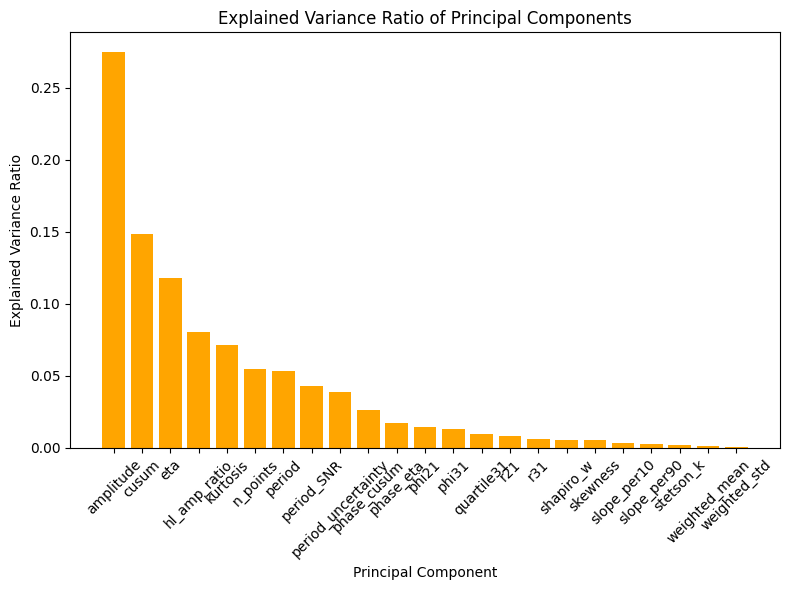

[0.27482813 0.42335149 0.54122109 0.62173513 0.69314423 0.74760196
 0.80072228 0.84386489 0.88242285 0.90855561 0.92617086 0.94091148
 0.95390151 0.96353844 0.97196269 0.97842732 0.98419334 0.98955678
 0.99284917 0.9955969  0.99776297 0.99908935 1.        ]


PCA()

In [4]:
def visualize_pca(df):
    # Assuming 'df' is your DataFrame with features

    # Standardize the data
    scaler = StandardScaler()
    scaled_data = scaler.fit_transform(df.iloc[:, :-1])

    # Perform PCA
    pca = PCA()
    pca.fit_transform(scaled_data)

    # Explained variance ratios
    explained_var = pca.explained_variance_ratio_

    # Plot explained variance ratios
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(explained_var) + 1), explained_var, align='center', color='orange')

    # Set feature names as x-axis ticks
    plt.xticks(range(1, len(explained_var) + 1), df.columns[:-1], rotation=45)  # Assuming last column is the target

    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    plt.title('Explained Variance Ratio of Principal Components')
    plt.tight_layout()
    plt.show()
    print(explained_var.cumsum())
    return pca

# Load the DF and call PCA
df = pd.read_csv('../csv_data/main_data/lc_data_LMC.csv')
features = df.drop(columns = ['id', 'class'])
labels = df.pop('class')
df.shape, np.unique(labels)
visualize_pca(df)

The first 10 features cover about 90% of the information. Knowing this the I would have discarded the remainder of the features when **extracting** them, since this took the majority of computational time. In the future I would do exactly that.

Let's now go to training

## 3. Model training

Here I will describe my decisions for choosing a specific model. Section 4. is more interesting!

First I read my data, extract features and labels, show the shape of the df and the classes in `labels` column.

In [5]:
df = pd.read_csv('../csv_data/main_data/lc_data_LMC.csv')
features = df.drop(columns = ['id', 'class'])
labels = df.pop('class')
df.shape, np.unique(labels)

((9862, 24), array(['Binary', 'Cepheid'], dtype=object))

Since the classes are `str` type which will cause some problems with the visualizers I use later, I will binarize them. `StandardScaler()` is called, but using it doesn't effect model performance, as mentioned, it is here just for good practice.

I have decided to use `RandomForestClassifier()` for it's capacity to learn to classify complex data. It also can classify multiple classes that will be useful in the future.

> Note: By chance, UPSILoN is also trained with `RandomForestClassifier()`. More on that in the [paper](https://arxiv.org/pdf/1512.01611.pdf)!

Standard train-test-split is applied and the model is either trained or loaded from `../models`. In our case it is loaded, but one can train it, it takes $<1s$.

At the end I call `.predict()` on for the test and train data to evaluate model performance for both phases.

In [6]:
# Create a LabelBinarizer object to binarize the labels
lb = LabelBinarizer()

# Binarize the label array (transform labels into binary form)
binarized_labels = lb.fit_transform(labels).ravel()

# Standardize the features using StandardScaler
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, binarized_labels, test_size=0.3)

# Check if the model file exists in the specified directory
if 'rand_forest_model.joblib' not in os.listdir('../models/'):
    # If the model file doesn't exist, create a new RandomForestClassifier model
    cls = RandomForestClassifier(random_state=42)
    rand_forest = cls.fit(X_train, y_train)  # Train the RandomForestClassifier model
    y_pred_test = rand_forest.predict(X_test)  # Make predictions on the test set
    y_pred_train = rand_forest.predict(X_train)  # Make predictions on the training set

    # Save the trained model to a file
    joblib.dump(rand_forest, 'rand_forest_model.joblib')
else:
    # If the model file exists, load the pre-trained model
    rand_forest = joblib.load('../models/rand_forest_model.joblib')
    y_pred_test = rand_forest.predict(X_test)  # Make predictions on the test set using the loaded model
    y_pred_train = rand_forest.predict(X_train)  # Make predictions on the training set using the loaded model

Now let's have a quick look:

In [7]:
print('Train data ------------------------------------------')
print(classification_report(y_train, y_pred_train))
print('Test data -------------------------------------------')
print(classification_report(y_test, y_pred_test))

Train data ------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3404
           1       1.00      1.00      1.00      3499

    accuracy                           1.00      6903
   macro avg       1.00      1.00      1.00      6903
weighted avg       1.00      1.00      1.00      6903

Test data -------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1527
           1       1.00      1.00      1.00      1432

    accuracy                           1.00      2959
   macro avg       1.00      1.00      1.00      2959
weighted avg       1.00      1.00      1.00      2959



100% ?! Sound like an overfit!

## 4. Testing and validation

 Now the cool stuff. It it will be interesting to how the model learns the data and where it has the biggest problems. 

 Let's see what happens to the features in our model.

 First let's plot feature importances. `RandomForestClassifier()` has a method called that, that returns the most important features *based on the mean decrease in node impurity* (meaning, for example the Gini index).

In [8]:
# Check if 'rand_forest' is an instance of RandomForestClassifier
if isinstance(rand_forest, RandomForestClassifier):
    # Calculate feature importances using the RandomForestClassifier model
    importances = rand_forest.feature_importances_
    
    # Create a DataFrame to store feature importances along with their respective names
    feature_importance_df = pd.DataFrame({'Feature': features.columns, 'Importance': importances})
    
    # Sort the DataFrame by importance values in descending order
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)
    
    # Print the sorted feature importance DataFrame
    print(feature_importance_df)


               Feature  Importance
4             kurtosis    0.217807
17            skewness    0.194934
5             n_points    0.123354
3         hl_amp_ratio    0.116732
7           period_SNR    0.073611
10           phase_eta    0.061357
20           stetson_k    0.044015
21       weighted_mean    0.039096
13          quartile31    0.030198
16           shapiro_w    0.028663
14                 r21    0.016530
6               period    0.007216
15                 r31    0.007077
19         slope_per90    0.007066
9          phase_cusum    0.006497
0            amplitude    0.006380
18         slope_per10    0.006047
8   period_uncertainty    0.004394
22        weighted_std    0.004146
1                cusum    0.001677
2                  eta    0.001424
11               phi21    0.001233
12               phi31    0.000546


It is interesting to note that here `kurtosis` has the biggest feature importance, and `amplitude` is way behind, which was different in the `PCA` analysis. Main reason is the difference in algorithms. `PCA` finds the features (vectors) that carry most variance, while `.feature_importances` shows how much each feature decreases impurity (entropy), there shouldn't be any correlation. Let's see that with feature correlation matrix.

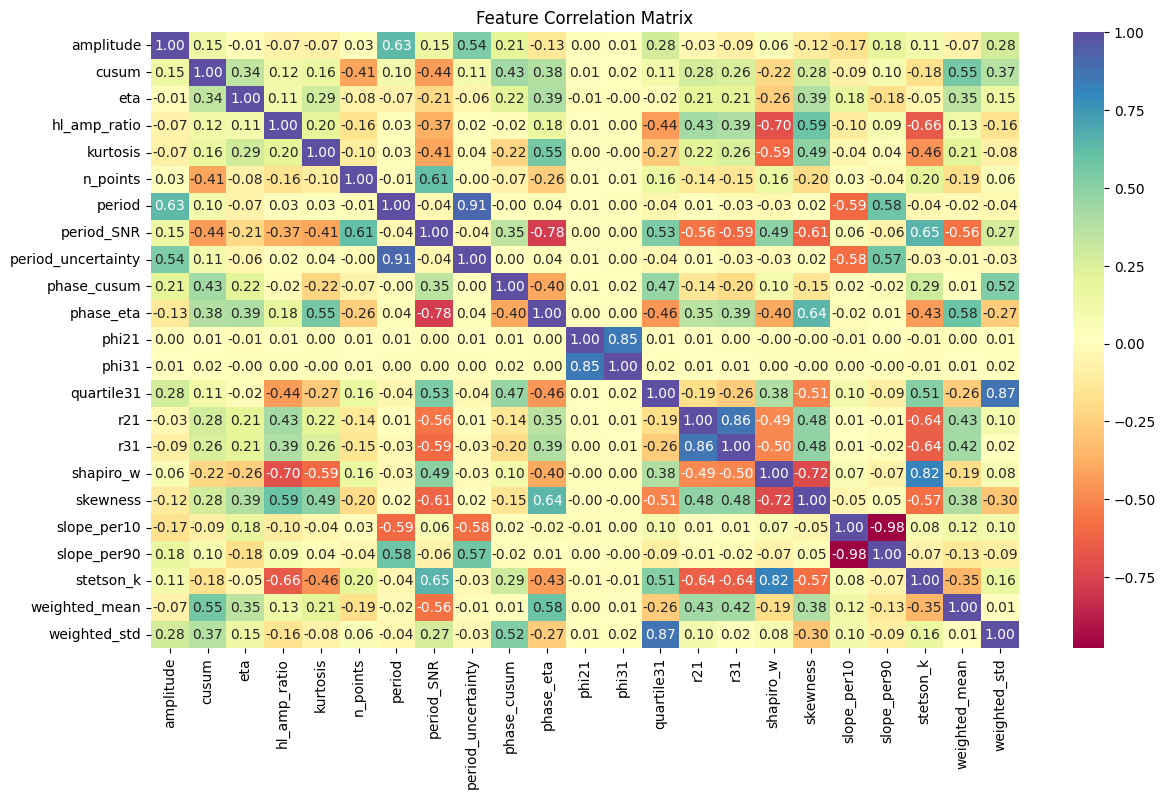

In [9]:
# Create a correlation matrix
correlation_matrix = features.corr()

# Plotting the correlation matrix
plt.figure(figsize=(14, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='Spectral', fmt=".2f")
plt.title('Feature Correlation Matrix')
plt.show()

The correlation between `kurtosis` and `amplitude` is -0.07, which is close to no correlation. 

Now let's see how the model learns. We will use `sklearn.learning_curve()` for that.

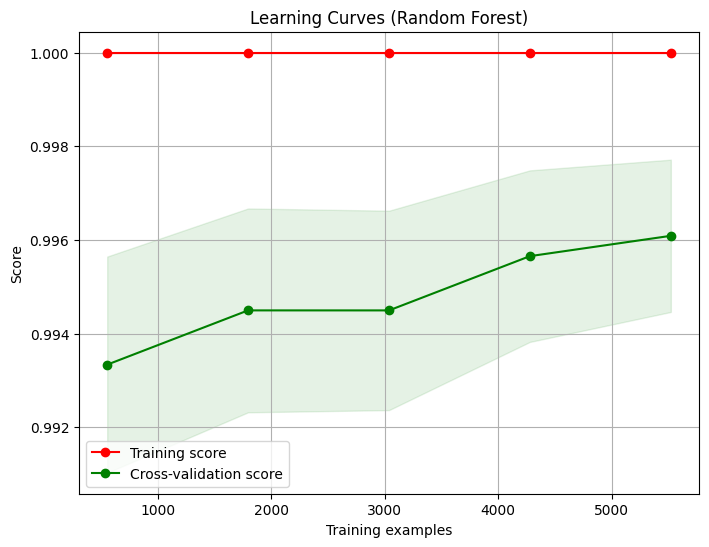

In [10]:
# Function to plot learning curve
# cv = None causes sklearn.learning_curve() to use its default cv (5-fold cv)
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, train_sizes=np.linspace(.1, 1.0, 5)):
    # Create a figure for plotting
    plt.figure(figsize=(8, 6))
    plt.title(title)  # Set the title for the plot

    # Set y-axis limits if provided
    if ylim is not None:
        plt.ylim(*ylim)

    # Set labels for x and y axes
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    # Generate learning curve data using scikit-learn's learning_curve function
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, train_sizes=train_sizes, scoring='accuracy', n_jobs=-1)

    # Calculate mean and standard deviation of training and test scores
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    # Add grid to the plot
    plt.grid()

    # Fill area around mean training score with red color
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")

    # Fill area around mean test score with green color
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    # Plot mean training score against training set sizes
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")

    # Plot mean test score against training set sizes
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    # Add legend to the plot
    plt.legend(loc="best")

    # Return the plot object
    return plt

# Plotting the learning curve
title = "Learning Curves (Random Forest)"
plot_learning_curve(rand_forest, title, X_train, y_train, cv=5)
plt.show()

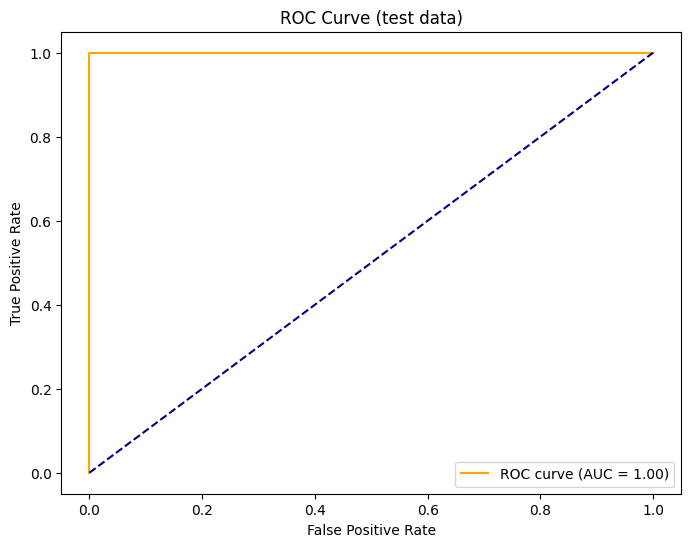

In [15]:
# Predict probabilities for class 1 
y_probs_test = rand_forest.predict_proba(X_test)[:, 1]

# Calculate the ROC curve metrics: false positive rate (fpr), true positive rate (tpr), and thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_probs_test)

# Calculate the Area Under the ROC Curve (AUC)
auc = roc_auc_score(y_test, y_probs_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))  # Set the figure size
plt.plot(fpr, tpr, color='orange', label='ROC curve (AUC = {:.2f})'.format(auc))  # Plot the ROC curve
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')  # Diagonal line representing random guessing
plt.xlabel('False Positive Rate')  # Label for the x-axis
plt.ylabel('True Positive Rate')  # Label for the y-axis
plt.title('ROC Curve (test data)')  # Title of the plot
plt.legend(loc='lower right')  # Display legend at the lower right corner
plt.show()  # Show the plot


It looks like the model strongly overfits! Accuracy score of 100% from the first trial of the model seems to be frank, *kinda sus*, even though it is on the test set. 

Let's see if we test the model on completely new data, will the results be similar. I have created two data sets for this job: `lc_data_BLG` and `lc_data_LMC`. Let's test how well the model can generalize on data taken from different parts of the night's sky!

First, here is a function that get's a dataset, calls the model to predict and spits out `ROC()`, `confusion_matrix()` and `classification_report()`.

In [12]:
def test_model(df: str, lb = lb):
    # Read the dataset and drop the 'Unnamed: 0' column
    data_set = pd.read_csv(df).drop(columns=['Unnamed: 0'])
    
    # Separate features and labels
    features = data_set.drop(columns=['id', 'class'])
    labels = data_set.pop('class')

    # Binarize the labels using LabelBinarizer
    binarized_labels = lb.fit_transform(labels).ravel()

    # Standardize the features
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)

    # Make predictions using the 'rand_forest' model (assuming it's defined outside this function)
    y_pred = rand_forest.predict(scaled_features)

    # Predict probabilities for class 1
    y_probs_test = rand_forest.predict_proba(features)[:, 1]

    # Calculate ROC curve metrics: false positive rate, true positive rate, and thresholds
    fpr, tpr, thresholds = roc_curve(binarized_labels, y_probs_test)

    # Calculate the AUC score
    auc = roc_auc_score(binarized_labels, y_probs_test)

    # Plotting side by side
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Extract the title from the file path
    title = df.split('.csv')[0].split('/main_data/')[1]

    # Plot ROC curve
    axes[0].plot(fpr, tpr, color='orange', label=f'ROC curve (AUC = {auc:.2f})')
    axes[0].plot([0, 1], [0, 1], color='green', linestyle='--')
    axes[0].set_xlabel('False Positive Rate')
    axes[0].set_ylabel('True Positive Rate')
    axes[0].set_title(f'ROC Curve ({title})')
    axes[0].legend(loc='lower right')

    # Confusion Matrix
    conf_matrix_train = confusion_matrix(binarized_labels, y_pred)
    sns.heatmap(conf_matrix_train, annot=True, cmap='Oranges', fmt='d', ax=axes[1])
    axes[1].set_title(f'Confusion Matrix ({title})')
    axes[1].set_xlabel('Predicted Label')
    axes[1].set_ylabel('True Label')

    plt.tight_layout()  # Adjust layout to prevent overlap
    plt.show()  # Display the plots

    # Print classification report
    print(classification_report(binarized_labels, y_pred))

c:\Users\momch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


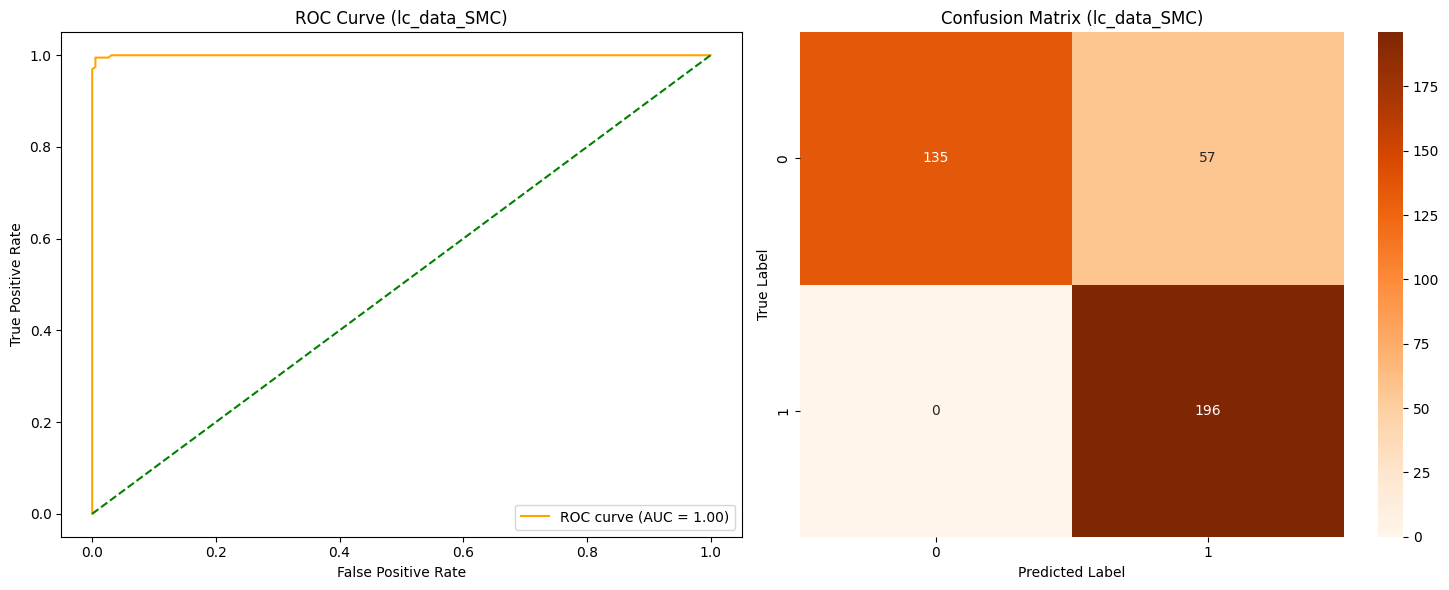

              precision    recall  f1-score   support

           0       1.00      0.70      0.83       192
           1       0.77      1.00      0.87       196

    accuracy                           0.85       388
   macro avg       0.89      0.85      0.85       388
weighted avg       0.89      0.85      0.85       388



c:\Users\momch\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:464: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


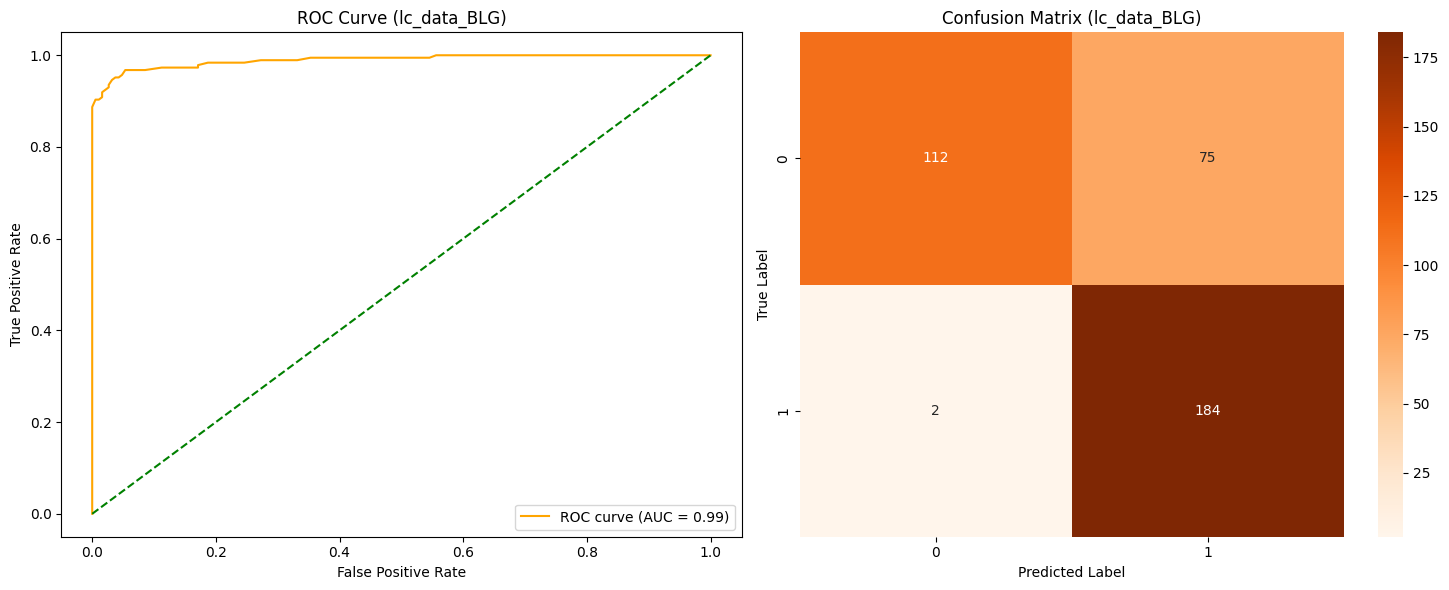

              precision    recall  f1-score   support

           0       0.98      0.60      0.74       187
           1       0.71      0.99      0.83       186

    accuracy                           0.79       373
   macro avg       0.85      0.79      0.79       373
weighted avg       0.85      0.79      0.79       373



In [13]:
test_model('../csv_data/main_data/lc_data_SMC.csv', lb = lb)
test_model('../csv_data/main_data/lc_data_BLG.csv', lb = lb)

Judging by the recall scores, the model's recall score (0.7 and 0.6) for the first class, *Binary*, the model doesn't generalize that well. We can sit that it misclassifies 1/3 of the binary systems as cepheids. Further optimization, training and testing is needed.

## 5. Conclusion

I had a lot of struggles with the time series, and most of my time unfortunately went into troubleshooting and I wished I had more time playing around with the model and testing it.

## 6. References

- [Kim & Bailer-Jones (2015) Paper](https://arxiv.org/abs/1512.01611)
- [UPSILoN GitHub Repository](https://github.com/dwkim78/upsilon/tree/master)
- [Sloan Digital Sky Survey (SDSS)](https://www.sdss.org/)
- [Nyquist Sampling Theorem - Google Search](https://www.google.com/search?q=nyquist&oq=nyquist&gs_lcrp=EgZjaHJvbWUyCQgAEEUYORiABDIHCAEQABiABDIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIHCAYQABiABDIHCAcQABiABDIHCAgQABiABDIHCAkQABiABNIBCDE2MzVqMGoxqAIAsAIA&sourceid=chrome&ie=UTF-8)
- [OGLE Collection of Variable Stars (OCVS)](https://www.astrouw.edu.pl/ogle/ogle4/OCVS/gd/cep/)
- [OCVS - Photometric Data](https://www.astrouw.edu.pl/ogle/ogle4/OCVS/gd/cep/phot/I/)
- [OGLE Database](https://ogledb.astrouw.edu.pl/~ogle/OCVS/)
- [SIMBAD Astronomical Database](https://simbad.u-strasbg.fr/simbad/)
- [Astroquery Documentation](https://astroquery.readthedocs.io/en/latest/#using-astroquery)
- [VizieR Astronomical Catalog Service - Google Search](https://www.google.com/search?q=vizier&oq=vizier&gs_lcrp=EgZjaHJvbWUyCQgAEEUYORiABDIHCAEQABiABDIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIHCAYQABiABDIHCAcQABiABDIHCAgQABiABDIHCAkQABiABNIBCDExOTNqMGoxqAIAsAIA&sourceid=chrome&ie=UTF-8)
- [SDSS - Sloan Digital Sky Survey - Google Search](https://www.google.com/search?q=sloan+digital+sky+survey&oq=SLOAN+digital+&gs_lcrp=EgZjaHJvbWUqBwgAEAAYgAQyBwgAEAAYgAQyBggBEEUYOTIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIHCAYQABiABDIGCAcQRRg80gEIMzU4NWowajGoAgCwAgA&sourceid=chrome&ie=UTF-8)
- [VizieR Astronomical Catalog Service - Google Search](https://www.google.com/search?q=vizier&oq=vizier&gs_lcrp=EgZjaHJvbWUqCwgAEEUYJxg7GIoFMgsIABBFGCcYOxiKBTIHCAEQABiABDIHCAIQABiABDIHCAMQABiABDIHCAQQABiABDIHCAUQABiABDIGCAcQRRg80gEIMzU4NWowajGoAgCwAgA&sourceid=chrome&ie=UTF-8)
- [MAST Portal](https://mast.stsci.edu/portal/Mashup/Clients/Mast/Portal.html)
- [Institute for Advanced Study - Criticism](https://en.wikipedia.org/wiki/Institute_for_Advanced_Study#Criticism)
- [Calmcode FAQ](https://calmcode.io/faq.html)
- [scikit-learn Stochastic Gradient Implementation](https://github.com/scikit-learn/scikit-learn/blob/main/sklearn/linear_model/_stochastic_gradient.py)
- [Using SGDClassifier with Partial Fit and Generators - Blog](https://jpinjpblog.wordpress.com/2019/04/16/using-sklearns-sgdclassifier-with-partial_fit-and-generators-gridsearchcv/)
- [SGDClassifier on Kaggle](https://www.kaggle.com/code/nsrose7224/sgdclassifier/notebook)
